# 1. Install Dependencies and Setup

In [1]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                                           Version
------------------------------------------------- ------------------
absl-py                                           2.1.0
aiobotocore                                       2.5.0
aiofiles                                          22.1.0
aiohappyeyeballs                                  2.4.0
aiohttp                                           3.10.5
aioitertools                                      0.7.1
aiosignal                                         1.2.0
aiosqlite                                         0.18.0
alabaster                                         0.7.16
altair                                            5.3.0
anaconda-anon-usage                               0.4.4
anaconda-catalogs                                 0.2.0
anaconda-client                                   1.12.3
anaconda-cloud-auth                               0.5.1
anaconda-navigator                                2.6.2
anaconda-project            

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

/var/folders/ft/td0zfb4x2q1ckmfys13d5l240000gp/T/ipykernel_45919/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

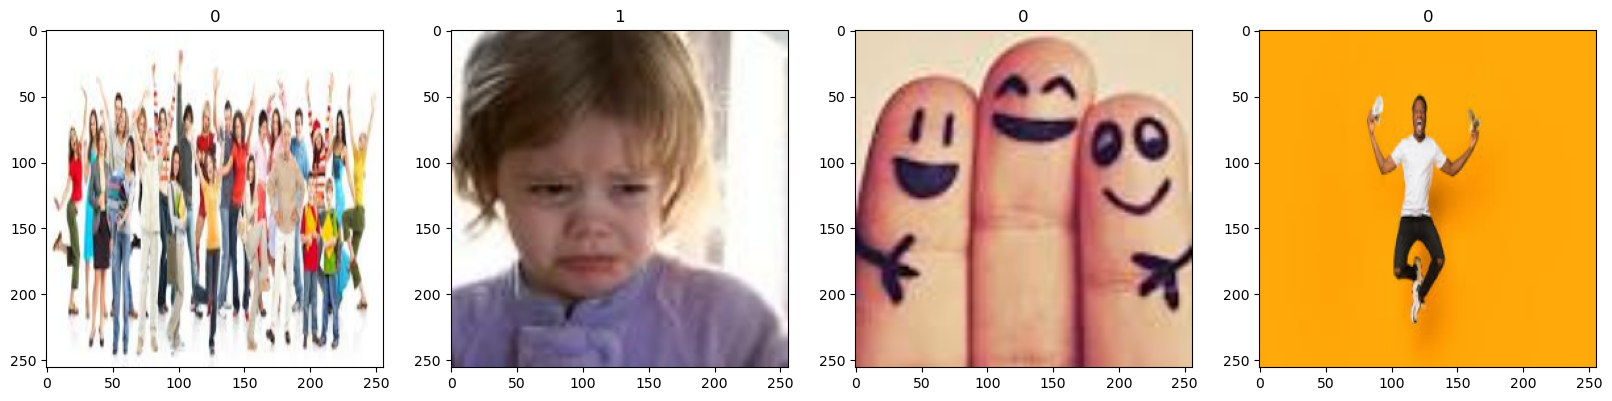

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          ...,
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02]],
 
         [[2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          ...,
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02]],
 
         [[2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          ...,
          [2.35294122e-02, 2.35294122e-02, 2.3529

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

7

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Users/shaurya/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - accuracy: 0.3879 - loss: 1.3900 - val_accuracy: 0.7344 - val_loss: 0.6819
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - accuracy: 0.6613 - loss: 0.6763 - val_accuracy: 0.6562 - val_loss: 0.6305
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 494ms/step - accuracy: 0.6828 - loss: 0.6219 - val_accuracy: 0.7969 - val_loss: 0.5674
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step - accuracy: 0.7550 - loss: 0.5596 - val_accuracy: 0.7344 - val_loss: 0.5822
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - accuracy: 0.7694 - loss: 0.5645 - val_accuracy: 0.7656 - val_loss: 0.5060
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - accuracy: 0.8364 - loss: 0.4828 - val_accuracy: 0.9219 - val_loss: 0.2811
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - accuracy: 0.8795 - loss: 0.3100 - val_accuracy: 0.9375 - val_loss: 0.2560
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - accuracy: 0.8844 - loss: 0.2729 - val_accuracy: 0.9219 - val_loss:

# 8. Plot Performance

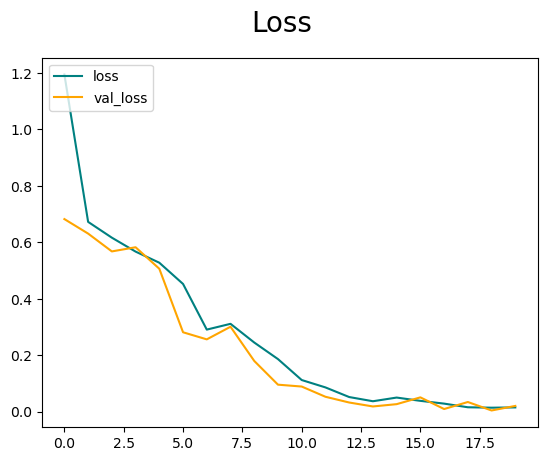

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

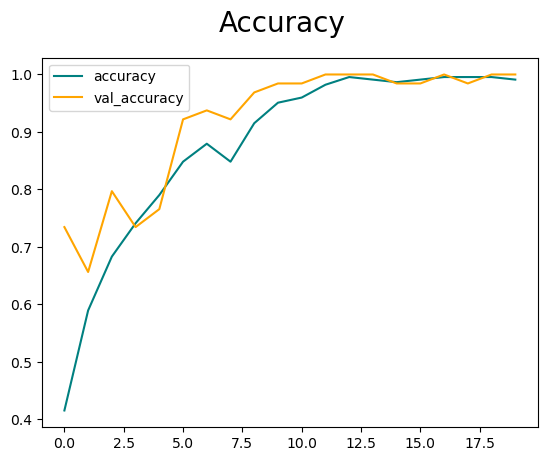

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


2024-09-27 22:16:04.709973: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

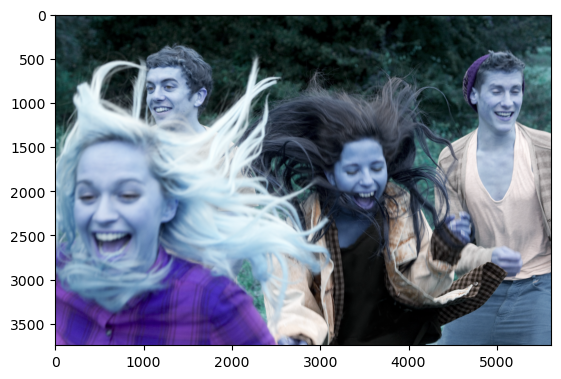

In [36]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

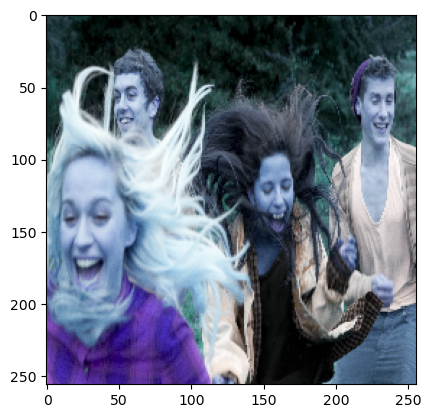

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [39]:
yhat

array([[0.00036112]], dtype=float32)

In [40]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
#model.save(os.path.join('models','imageclassifier.h5'))
model.save(os.path.join('models', 'imageclassifier.keras'))


In [43]:
#new_model = load_model('imageclassifier.h5')
new_model = load_model(os.path.join('models', 'imageclassifier.keras'))


In [44]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [45]:
if yhatnew > 0.5:
    print(f'Predicted class is sad')
else:
    print(f'Predicted class is happy')

Predicted class is happy
